# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

# 
# Read Data

In [2]:
df = pd.read_csv('games-regression-dataset.csv')

In [3]:
df.shape

(5214, 18)

# 
# Functions

**`PreprocessListCategories`** <br>
`Function take df, list of categories columns and apply OHE on them, then return the df after modifications`

In [4]:
def PreprocessListCategories(df, lst):
    for col in lst:
        # Apply one-hot encoding to the "col" column in list and put the output in newdf
        newdf = df[col].str.get_dummies(sep=', ')
        
        # Concatenate the one-hot encoded columns with the original DataFrame
        df = pd.concat([df, newdf], axis=1)
        
    return df

**`CheckNullRows`**<br>
`Function take df and print number of null rows`

In [5]:
def CheckNullRows(df):
    missing_rows = df.isnull().any(axis=1).sum()
    print('Number of rows that have null values: ', missing_rows)

**`DropNullRows`**<br>
`Function take df and drop all null rows`

In [6]:
def DropNullRows(df):
    df.dropna(inplace=True)

**`ChangeDataType`**<br>
`Function take df and change data types of some columns to appropriate data type`

In [7]:
def PreProcessAgrRating(df):
    # Age Rating 
    # Print current data type
    # print('Data type of Age Rating is, ', df['Age Rating'].dtype)
    # Remove the + sign
    df['Age Rating'] = df['Age Rating'].str.replace('+', '', regex=False)
    # Convert Column datatype to int
    df['Age Rating'] = df['Age Rating'].astype(int)
    # print('Data type of Age Rating after processing is ', df['Age Rating'].dtype)
    # Create a dictionary to map the age ratings to integers
    age_rating_map = {4: 1, 9: 2, 12: 3, 17: 4}
    # Replace each value with its category
    df['Age Rating'] = df['Age Rating'].replace(age_rating_map)
    # Print Age Rating
    print(df['Age Rating'].head())

In [8]:
def ConvertToDateTime(df, lst):
    for col in lst:
        df[col] = pd.to_datetime(df[col])

In [9]:
def GetColumnsNullsPerc(df):
    # print count of nulls for each column and percentage of them
    missing_data = pd.DataFrame({'total_missing': df.isnull().sum(), 'perc_missing': (df.isnull().mean())*100})
    return missing_data

In [10]:
def CheckListOfCategoriesColumn(df, col):
    print("Data type of ", col, "column is: ", df[col].dtype)
    all_columns = list(set(','.join(df[col].fillna('').unique()).split(',')))
    print(col, "column has ", len(all_columns), "unique", col)

In [11]:
def PrintDfColumns(df):
    columns_list = df.columns.tolist()
    print(columns_list)

In [12]:
def FillColumnNulls(df, col):
    df[col] = df[col].fillna(0)

In [13]:
def DuplicatesDetectionAndRemoval(df):
    print("Number of duplicates rows: ", df.duplicated().sum())
    df.drop_duplicates(inplace = True, keep="first")

In [14]:
def outliers(dataset,col):
    fig, ax =plt.subplots(1,2)
    sns.boxplot( y=col, data=dataset,color="red", ax=ax[0])
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1-1.5*IQR
    upper_bound = Q3+1.5*IQR
    dataset[col]=dataset[col].apply(lambda x: upper_bound if x> upper_bound else( lower_bound if x< lower_bound  else x))        
    sns.boxplot( y=col, data=dataset,color="blue", ax=ax[1])
    fig.show()

In [15]:
def avarage_Purchases(data,col):
    data[col]=data[col].fillna("0")
    data[col]=data[col].astype(str)
    data[col]=data[col].str.split(",")
    data[col]=[np.float64(x) for x in data[col]]
    from statistics import mean
    for i in range(data.shape[0]):
        data[col][i]=mean(data[col][i])
    data[col]=data[col].astype(float)
    return data

In [16]:
def calc_duration(df):
    # Calculate the difference in years and add 1
    # add 1 for each row because if Years Since Release =0 make it 1 to avoid multipy by 0 in training model
    df['Years Since Release'] = (df['Current Version Release Date'].dt.year - df['Original Release Date'].dt.year) + 1

In [17]:
def calcDfZeroPerc(df):
    zero_percentage = pd.DataFrame({'total_zeros': (df == 0).sum(), 'perc_zeros': (df == 0).mean() * 100})
    return zero_percentage

In [18]:
def reduceOHEColumns(df):
    X = df.iloc[:,18:] #columns of categories [languages, generes, ]
    zero_percentage = pd.DataFrame({'total_zeros': (X == 0).sum(), 'perc_zeros': (X == 0).mean() * 100})
    to_keep = zero_percentage['perc_zeros'] < 90
    
    updatedX = X.loc[:, to_keep]
    df = df.drop(df.columns[18:], axis=1)
    
    result = pd.concat([df, updatedX], axis=1)
    return result

In [19]:
def dropColumns(df, lst):
    for col in lst:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)

In [20]:
def scaling(df):
    #use Min-Max scaling, which scales the data to a range between 0 and 1.
    # Initialize the MinMaxScaler object
    scalerA = MinMaxScaler()
    scalerB = MinMaxScaler()
    # Fit and transform the features
    df['User Rating Count'] = scalerA.fit_transform(df[['User Rating Count']])
    df['Size'] = scalerB.fit_transform(df[['Size']])
    return df

In [21]:
def preprocessingPart1(df):
    # Age Rating Column 
    PreProcessAgrRating(df)
    
    df.drop(columns=['Subtitle'], inplace=True)
    
    # Add dates in another cell to run it twice and remove warning 
    
    FillColumnNulls(df, 'In-app Purchases')
    df = avarage_Purchases(df, 'In-app Purchases')
    
    DropNullRows(df)
    
    DuplicatesDetectionAndRemoval(df)
    
    outliarlist=["User Rating Count","Size"]
    for i in outliarlist:
        outliers(df,i)
        
    # replace tst with df
    df = PreprocessListCategories(df,['Primary Genre', 'Genres', 'Languages'])
    return df

# 
# Preprocessing Pipeline
- **`1. Columns Analysis `**
- **`2. Columns Nulls`**
- **`3. Rows Nulls`**
- **`4. Duplicates`**
- **`5. Outlires Detection & Removal`**
- **`6. Deal With Categories`**

In [22]:
PrintDfColumns(df)

['URL', 'ID', 'Name', 'Subtitle', 'Icon URL', 'User Rating Count', 'Price', 'In-app Purchases', 'Description', 'Developer', 'Age Rating', 'Languages', 'Size', 'Primary Genre', 'Genres', 'Original Release Date', 'Current Version Release Date', 'Average User Rating']


In [23]:
df.head()

,URL,ID,Name,Subtitle,Icon URL,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date,Average User Rating
0,https://apps.apple.com/us/app/heir-of-light/id...,1264483706,HEIR OF LIGHT,Dark Fantasy RPG,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,982,0.00,"29.99, 19.99, 9.99, 29.99, 29.99, 8.99, 4.99, ...","A Dark Fantasy, Collectible RPG\n\nDarkness ha...",GAMEVIL Inc.,12+,"EN, FR, DE, JA, KO, ZH, ES, TH, ZH, VI",894489600,Games,"Games, Role Playing, Strategy",6/3/2018,31/07/2019,4.0
1,https://apps.apple.com/us/app/endgame-eurasia/...,607705356,Endgame:Eurasia,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,19,0.00,NaN,"""This interactive experience is an exploration...",Auroch Digital Ltd,12+,EN,116407296,Games,"Games, Simulation, Strategy, News",21/03/2013,28/06/2017,3.5
2,https://apps.apple.com/us/app/free-solitaire/i...,627491527,Free Solitaire+,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,14,0.00,NaN,Same Solitaire game with classic Solitaire run...,Chen Zhong Yuan,4+,"EN, ZH",50647040,Games,"Games, Strategy, Entertainment, Card",4/4/2013,21/04/2015,4.5
3,https://apps.apple.com/us/app/draft-trainer/id...,430252596,Draft Trainer,NaN,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,88,1.99,NaN,** Discounted for a limited time **\n\nEver wo...,"GG Wizards, LLC",9+,EN,28120064,Games,"Games, Utilities, Card, Strategy",26/05/2011,23/07/2019,3.5
4,https://apps.apple.com/us/app/rogue-knight-inf...,1115082819,Rogue Knight: Infested Lands,Tactical roguelike w/ stealth,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,13,3.99,NaN,Fight or sneak your way through hordes of mons...,Luis Regueira,12+,EN,39915520,Games,"Games, Role Playing, Strategy",19/05/2017,6/2/2019,4.5


## 
### `1. Columns Analysis`

In [24]:
df.dtypes

URL                              object
ID                                int64
Name                             object
Subtitle                         object
Icon URL                         object
User Rating Count                 int64
Price                           float64
In-app Purchases                 object
Description                      object
Developer                        object
Age Rating                       object
Languages                        object
Size                              int64
Primary Genre                    object
Genres                           object
Original Release Date            object
Current Version Release Date     object
Average User Rating             float64
dtype: object

<br> 

**Age Rating**
- Remove + sign 
- Convert to int
- Notice that the column has only 4 ages so we can categorize them

In [25]:
PreProcessAgrRating(df)

0    3
1    3
2    1
3    2
4    3
Name: Age Rating, dtype: int32


<br>

**Languages**

In [26]:
CheckListOfCategoriesColumn(df, 'Languages')

Data type of  Languages column is:  object
Languages column has  130 unique Languages


<br>

**Genres**

In [27]:
CheckListOfCategoriesColumn(df, 'Genres')

Data type of  Genres column is:  object
Genres column has  56 unique Genres


<br>

**Primary Genre**

In [28]:
CheckListOfCategoriesColumn(df, 'Primary Genre')

Data type of  Primary Genre column is:  object
Primary Genre column has  19 unique Primary Genre


## 
**Dates**
- Convert to date time data type

In [29]:
ConvertToDateTime(df, ['Original Release Date', 'Current Version Release Date'])

C:\Users\abdos\AppData\Local\Temp\ipykernel_8316\3100620117.py:3: UserWarning: Parsing '21/03/2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df[col] = pd.to_datetime(df[col])
C:\Users\abdos\AppData\Local\Temp\ipykernel_8316\3100620117.py:3: UserWarning: Parsing '26/05/2011' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df[col] = pd.to_datetime(df[col])
C:\Users\abdos\AppData\Local\Temp\ipykernel_8316\3100620117.py:3: UserWarning: Parsing '19/05/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df[col] = pd.to_datetime(df[col])
C:\Users\abdos\AppData\Local\Temp\ipykernel_8316\3100620117.py:3: UserWarning: Parsing '14/11/2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df[col] = pd.to_datetime(df[col])
C:\Users\abdos\AppData\Local\Temp\ipykernel_8316\3100620117.

C:\Users\abdos\AppData\Local\Temp\ipykernel_8316\3100620117.py:3: UserWarning: Parsing '21/11/2015' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df[col] = pd.to_datetime(df[col])
C:\Users\abdos\AppData\Local\Temp\ipykernel_8316\3100620117.py:3: UserWarning: Parsing '24/04/2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df[col] = pd.to_datetime(df[col])
C:\Users\abdos\AppData\Local\Temp\ipykernel_8316\3100620117.py:3: UserWarning: Parsing '20/06/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df[col] = pd.to_datetime(df[col])
C:\Users\abdos\AppData\Local\Temp\ipykernel_8316\3100620117.py:3: UserWarning: Parsing '18/05/2014' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df[col] = pd.to_datetime(df[col])
C:\Users\abdos\AppData\Local\Temp\ipykernel_8316\3100620117.

In [30]:
calc_duration(df)

In [31]:
df.head()

,URL,ID,Name,Subtitle,Icon URL,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date,Average User Rating,Years Since Release
0,https://apps.apple.com/us/app/heir-of-light/id...,1264483706,HEIR OF LIGHT,Dark Fantasy RPG,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,982,0.00,"29.99, 19.99, 9.99, 29.99, 29.99, 8.99, 4.99, ...","A Dark Fantasy, Collectible RPG\n\nDarkness ha...",GAMEVIL Inc.,3,"EN, FR, DE, JA, KO, ZH, ES, TH, ZH, VI",894489600,Games,"Games, Role Playing, Strategy",2018-06-03,2019-07-31,4.0,2
1,https://apps.apple.com/us/app/endgame-eurasia/...,607705356,Endgame:Eurasia,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,19,0.00,NaN,"""This interactive experience is an exploration...",Auroch Digital Ltd,3,EN,116407296,Games,"Games, Simulation, Strategy, News",2013-03-21,2017-06-28,3.5,5
2,https://apps.apple.com/us/app/free-solitaire/i...,627491527,Free Solitaire+,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,14,0.00,NaN,Same Solitaire game with classic Solitaire run...,Chen Zhong Yuan,1,"EN, ZH",50647040,Games,"Games, Strategy, Entertainment, Card",2013-04-04,2015-04-21,4.5,3
3,https://apps.apple.com/us/app/draft-trainer/id...,430252596,Draft Trainer,NaN,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,88,1.99,NaN,** Discounted for a limited time **\n\nEver wo...,"GG Wizards, LLC",2,EN,28120064,Games,"Games, Utilities, Card, Strategy",2011-05-26,2019-07-23,3.5,9
4,https://apps.apple.com/us/app/rogue-knight-inf...,1115082819,Rogue Knight: Infested Lands,Tactical roguelike w/ stealth,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,13,3.99,NaN,Fight or sneak your way through hordes of mons...,Luis Regueira,3,EN,39915520,Games,"Games, Role Playing, Strategy",2017-05-19,2019-06-02,4.5,3


## 
### `2. Columns Nulls`

In [32]:
GetColumnsNullsPerc(df)

,total_missing,perc_missing
URL,0,0.000000
ID,0,0.000000
Name,0,0.000000
Subtitle,3749,71.902570
Icon URL,0,0.000000
User Rating Count,0,0.000000
Price,0,0.000000
In-app Purchases,2039,39.106252
Description,0,0.000000
Developer,0,0.000000


In [33]:
df.drop(columns=['Subtitle'], inplace=True)

In [34]:
GetColumnsNullsPerc(df)

,total_missing,perc_missing
URL,0,0.000000
ID,0,0.000000
Name,0,0.000000
Icon URL,0,0.000000
User Rating Count,0,0.000000
Price,0,0.000000
In-app Purchases,2039,39.106252
Description,0,0.000000
Developer,0,0.000000
Age Rating,0,0.000000



<br> 

**In-app Purchases**
- We can assum that any cell with null value, does not has any purshases. So replace all nulls with 0
- Replce each cell with the mean

In [35]:
FillColumnNulls(df, 'In-app Purchases')

In [36]:
GetColumnsNullsPerc(df)

,total_missing,perc_missing
URL,0,0.00000
ID,0,0.00000
Name,0,0.00000
Icon URL,0,0.00000
User Rating Count,0,0.00000
Price,0,0.00000
In-app Purchases,0,0.00000
Description,0,0.00000
Developer,0,0.00000
Age Rating,0,0.00000


In [37]:
# todo (replace with mean)

In [38]:
df = avarage_Purchases(df, 'In-app Purchases')

C:\Users\abdos\AppData\Local\Temp\ipykernel_8316\3875886820.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][i]=mean(data[col][i])


In [39]:
df['In-app Purchases'].dtype

dtype('float64')

## 

## `3. Rows Nulls`

In [40]:
df.shape

(5214, 18)

In [41]:
CheckNullRows(df)

Number of rows that have null values:  11


In [42]:
DropNullRows(df)

In [43]:
CheckNullRows(df)

Number of rows that have null values:  0


In [44]:
df.shape

(5203, 18)

<br>

## `4. Duplicates`

In [45]:
DuplicatesDetectionAndRemoval(df)

Number of duplicates rows:  43


In [46]:
df.shape

(5160, 18)

<br>

## `5. Outlires Detection & Removal`

C:\Users\abdos\AppData\Local\Temp\ipykernel_8316\2188112770.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\abdos\AppData\Local\Temp\ipykernel_8316\2188112770.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


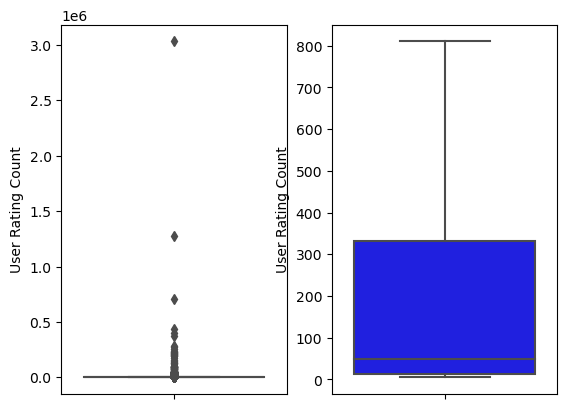

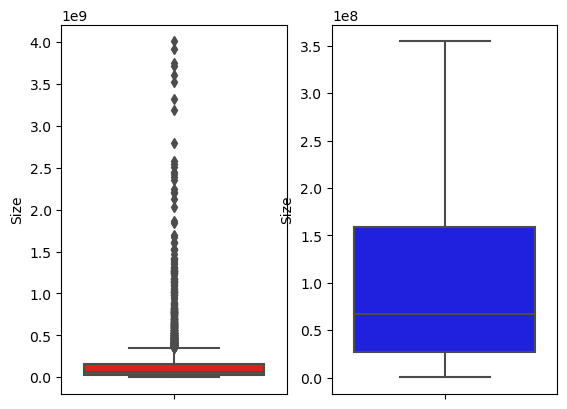

In [47]:
outliarlist=["User Rating Count","Size"]
for i in outliarlist:
    outliers(df,i)

<br>

## `6. Apply One Hot Encoding On Categories`

In [48]:
# replace tst with df
df = PreprocessListCategories(df,['Primary Genre', 'Genres', 'Languages'])

In [49]:
df.shape

(5160, 189)

In [50]:
df.to_csv('out.csv')

In [51]:
df.head()

,URL,ID,Name,Icon URL,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,...,TR,TT,UG,UK,UR,UZ,VI,YI,ZH,ZU
0,https://apps.apple.com/us/app/heir-of-light/id...,1264483706,HEIR OF LIGHT,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,810.5,0.00,19.24,"A Dark Fantasy, Collectible RPG\n\nDarkness ha...",GAMEVIL Inc.,3,...,0,0,0,0,0,0,1,0,1,0
1,https://apps.apple.com/us/app/endgame-eurasia/...,607705356,Endgame:Eurasia,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,19.0,0.00,0.00,"""This interactive experience is an exploration...",Auroch Digital Ltd,3,...,0,0,0,0,0,0,0,0,0,0
2,https://apps.apple.com/us/app/free-solitaire/i...,627491527,Free Solitaire+,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,14.0,0.00,0.00,Same Solitaire game with classic Solitaire run...,Chen Zhong Yuan,1,...,0,0,0,0,0,0,0,0,1,0
3,https://apps.apple.com/us/app/draft-trainer/id...,430252596,Draft Trainer,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,88.0,1.99,0.00,** Discounted for a limited time **\n\nEver wo...,"GG Wizards, LLC",2,...,0,0,0,0,0,0,0,0,0,0
4,https://apps.apple.com/us/app/rogue-knight-inf...,1115082819,Rogue Knight: Infested Lands,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,13.0,3.99,0.00,Fight or sneak your way through hordes of mons...,Luis Regueira,3,...,0,0,0,0,0,0,0,0,0,0


In [52]:
PrintDfColumns(df)

['URL', 'ID', 'Name', 'Icon URL', 'User Rating Count', 'Price', 'In-app Purchases', 'Description', 'Developer', 'Age Rating', 'Languages', 'Size', 'Primary Genre', 'Genres', 'Original Release Date', 'Current Version Release Date', 'Average User Rating', 'Years Since Release', 'Book', 'Business', 'Education', 'Entertainment', 'Finance', 'Food & Drink', 'Games', 'Health & Fitness', 'Lifestyle', 'Medical', 'Music', 'News', 'Productivity', 'Reference', 'Shopping', 'Social Networking', 'Sports', 'Stickers', 'Utilities', 'Action', 'Adventure', 'Board', 'Books', 'Business', 'Card', 'Casino', 'Casual', 'Education', 'Emoji & Expressions', 'Entertainment', 'Family', 'Finance', 'Food & Drink', 'Games', 'Gaming', 'Health & Fitness', 'Kids & Family', 'Lifestyle', 'Medical', 'Music', 'Navigation', 'News', 'Photo & Video', 'Productivity', 'Puzzle', 'Racing', 'Reference', 'Role Playing', 'Shopping', 'Simulation', 'Social Networking', 'Sports', 'Stickers', 'Strategy', 'Travel', 'Trivia', 'Utilities', '

<br>

## `7. Reduce OHE Columns`

In [53]:
df = reduceOHEColumns(df)

In [54]:
df.head()

,URL,Name,Icon URL,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,...,DE,EN,ES,FR,IT,JA,KO,PT,RU,ZH
0,https://apps.apple.com/us/app/heir-of-light/id...,HEIR OF LIGHT,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,810.5,0.00,19.24,"A Dark Fantasy, Collectible RPG\n\nDarkness ha...",GAMEVIL Inc.,3,"EN, FR, DE, JA, KO, ZH, ES, TH, ZH, VI",...,1,1,1,1,0,1,1,0,0,1
1,https://apps.apple.com/us/app/endgame-eurasia/...,Endgame:Eurasia,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,19.0,0.00,0.00,"""This interactive experience is an exploration...",Auroch Digital Ltd,3,EN,...,0,1,0,0,0,0,0,0,0,0
2,https://apps.apple.com/us/app/free-solitaire/i...,Free Solitaire+,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,14.0,0.00,0.00,Same Solitaire game with classic Solitaire run...,Chen Zhong Yuan,1,"EN, ZH",...,0,1,0,0,0,0,0,0,0,1
3,https://apps.apple.com/us/app/draft-trainer/id...,Draft Trainer,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,88.0,1.99,0.00,** Discounted for a limited time **\n\nEver wo...,"GG Wizards, LLC",2,EN,...,0,1,0,0,0,0,0,0,0,0
4,https://apps.apple.com/us/app/rogue-knight-inf...,Rogue Knight: Infested Lands,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,13.0,3.99,0.00,Fight or sneak your way through hordes of mons...,Luis Regueira,3,EN,...,0,1,0,0,0,0,0,0,0,0


In [55]:
PrintDfColumns(df)

['URL', 'Name', 'Icon URL', 'User Rating Count', 'Price', 'In-app Purchases', 'Description', 'Developer', 'Age Rating', 'Languages', 'Size', 'Primary Genre', 'Genres', 'Original Release Date', 'Current Version Release Date', 'Average User Rating', 'Years Since Release', 'Games', 'Action', 'Board', 'Entertainment', 'Games', 'Puzzle', 'Role Playing', 'Simulation', 'Strategy', 'DE', 'EN', 'ES', 'FR', 'IT', 'JA', 'KO', 'PT', 'RU', 'ZH']


<br>

## `8. Scaling`

In [56]:
df = scaling(df)

In [57]:
df.head()

,URL,Name,Icon URL,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,...,DE,EN,ES,FR,IT,JA,KO,PT,RU,ZH
0,https://apps.apple.com/us/app/heir-of-light/id...,HEIR OF LIGHT,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,1.000000,0.00,19.24,"A Dark Fantasy, Collectible RPG\n\nDarkness ha...",GAMEVIL Inc.,3,"EN, FR, DE, JA, KO, ZH, ES, TH, ZH, VI",...,1,1,1,1,0,1,1,0,0,1
1,https://apps.apple.com/us/app/endgame-eurasia/...,Endgame:Eurasia,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,0.017381,0.00,0.00,"""This interactive experience is an exploration...",Auroch Digital Ltd,3,EN,...,0,1,0,0,0,0,0,0,0,0
2,https://apps.apple.com/us/app/free-solitaire/i...,Free Solitaire+,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,0.011173,0.00,0.00,Same Solitaire game with classic Solitaire run...,Chen Zhong Yuan,1,"EN, ZH",...,0,1,0,0,0,0,0,0,0,1
3,https://apps.apple.com/us/app/draft-trainer/id...,Draft Trainer,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,0.103042,1.99,0.00,** Discounted for a limited time **\n\nEver wo...,"GG Wizards, LLC",2,EN,...,0,1,0,0,0,0,0,0,0,0
4,https://apps.apple.com/us/app/rogue-knight-inf...,Rogue Knight: Infested Lands,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,0.009932,3.99,0.00,Fight or sneak your way through hordes of mons...,Luis Regueira,3,EN,...,0,1,0,0,0,0,0,0,0,0


<br>

## `9. Feature Selection`

In [58]:
df.head()

,URL,Name,Icon URL,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,...,DE,EN,ES,FR,IT,JA,KO,PT,RU,ZH
0,https://apps.apple.com/us/app/heir-of-light/id...,HEIR OF LIGHT,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,1.000000,0.00,19.24,"A Dark Fantasy, Collectible RPG\n\nDarkness ha...",GAMEVIL Inc.,3,"EN, FR, DE, JA, KO, ZH, ES, TH, ZH, VI",...,1,1,1,1,0,1,1,0,0,1
1,https://apps.apple.com/us/app/endgame-eurasia/...,Endgame:Eurasia,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,0.017381,0.00,0.00,"""This interactive experience is an exploration...",Auroch Digital Ltd,3,EN,...,0,1,0,0,0,0,0,0,0,0
2,https://apps.apple.com/us/app/free-solitaire/i...,Free Solitaire+,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,0.011173,0.00,0.00,Same Solitaire game with classic Solitaire run...,Chen Zhong Yuan,1,"EN, ZH",...,0,1,0,0,0,0,0,0,0,1
3,https://apps.apple.com/us/app/draft-trainer/id...,Draft Trainer,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,0.103042,1.99,0.00,** Discounted for a limited time **\n\nEver wo...,"GG Wizards, LLC",2,EN,...,0,1,0,0,0,0,0,0,0,0
4,https://apps.apple.com/us/app/rogue-knight-inf...,Rogue Knight: Infested Lands,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,0.009932,3.99,0.00,Fight or sneak your way through hordes of mons...,Luis Regueira,3,EN,...,0,1,0,0,0,0,0,0,0,0


In [59]:
dropColumns(df, ['URL', 'Name', 'Icon URL', 'Description', 'Developer', 'Languages', 'Primary Genre', 'Genres', 'Original Release Date', 'Current Version Release Date'])

In [60]:
df.head()

,User Rating Count,Price,In-app Purchases,Age Rating,Size,Average User Rating,Years Since Release,Games,Action,Board,...,DE,EN,ES,FR,IT,JA,KO,PT,RU,ZH
0,1.000000,0.00,19.24,3,1.000000,4.0,2,1,0,0,...,1,1,1,1,0,1,1,0,0,1
1,0.017381,0.00,0.00,3,0.327609,3.5,5,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0.011173,0.00,0.00,1,0.142194,4.5,3,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0.103042,1.99,0.00,2,0.078678,3.5,9,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0.009932,3.99,0.00,3,0.111936,4.5,3,1,0,0,...,0,1,0,0,0,0,0,0,0,0


### Define Features and Target

In [61]:
Y = df['Average User Rating']

In [62]:
X = df.copy()

In [63]:
X.head()

,User Rating Count,Price,In-app Purchases,Age Rating,Size,Average User Rating,Years Since Release,Games,Action,Board,...,DE,EN,ES,FR,IT,JA,KO,PT,RU,ZH
0,1.000000,0.00,19.24,3,1.000000,4.0,2,1,0,0,...,1,1,1,1,0,1,1,0,0,1
1,0.017381,0.00,0.00,3,0.327609,3.5,5,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0.011173,0.00,0.00,1,0.142194,4.5,3,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0.103042,1.99,0.00,2,0.078678,3.5,9,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0.009932,3.99,0.00,3,0.111936,4.5,3,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [64]:
dropColumns(X, ['Average User Rating'])

In [65]:
X.head()

,User Rating Count,Price,In-app Purchases,Age Rating,Size,Years Since Release,Games,Action,Board,Entertainment,...,DE,EN,ES,FR,IT,JA,KO,PT,RU,ZH
0,1.000000,0.00,19.24,3,1.000000,2,1,0,0,0,...,1,1,1,1,0,1,1,0,0,1
1,0.017381,0.00,0.00,3,0.327609,5,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0.011173,0.00,0.00,1,0.142194,3,1,0,0,1,...,0,1,0,0,0,0,0,0,0,1
3,0.103042,1.99,0.00,2,0.078678,9,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0.009932,3.99,0.00,3,0.111936,3,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [66]:
PrintDfColumns(X)

['User Rating Count', 'Price', 'In-app Purchases', 'Age Rating', 'Size', 'Years Since Release', 'Games', 'Action', 'Board', 'Entertainment', 'Games', 'Puzzle', 'Role Playing', 'Simulation', 'Strategy', 'DE', 'EN', 'ES', 'FR', 'IT', 'JA', 'KO', 'PT', 'RU', 'ZH']


## Train Test

In [67]:
# First Split data into train, test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30,shuffle=True,random_state=10)

In [68]:
poly_features = PolynomialFeatures(degree=2)

In [69]:
X_train_poly = poly_features.fit_transform(X_train)

In [70]:
poly_model = linear_model.LinearRegression()

In [71]:
poly_model.fit(X_train_poly, y_train)

LinearRegression()

In [72]:
prediction = poly_model.predict(poly_features.fit_transform(X_test))

In [73]:
print('Mean Square Error', metrics.mean_squared_error(y_test, prediction))

Mean Square Error 810528237.3527197


In [74]:
cls = linear_model.LinearRegression()

In [75]:
cls.fit(X,Y)

LinearRegression()

In [76]:
prediction= cls.predict(X)

In [77]:
print('Mean Square Error', metrics.mean_squared_error(np.asarray(Y), prediction))

Mean Square Error 0.5256512969199293
